# Predicting House Sale Prices

We will work with housing data for the city of Ames, Iowa from 2006 - 2010.  Information on this data is available [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

We will use this data to practice different data preparation and linear regression techniques.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

In [2]:
# read data into dataframe
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Create Functions

Let's create a series of functions to allow us to transform the data, select different features for the model, train the model, and then test the model.  We can then continue to use these functions below.

We will start with a simple setup as a baseline using one feature, `Gr Liv Area`, and our target `SalePrice`.

In [4]:
# create simple transform_features()
def transform_features(df):
    return df

# create simple select_features()
def select_features(df):
    features = df[['Gr Liv Area', 'SalePrice']]
    return features

# create train_and_test()
def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
        
    features = train.columns.drop('SalePrice')
    X = train[features]
    y = train['SalePrice']
    
    reg = LinearRegression()
    reg.fit(X, y)
    predictions = reg.predict(test[features])
    rmse = mean_squared_error(test['SalePrice'], predictions) ** (1/2)
    return rmse

# run the basic model on just this one feature 'Gr Liv Area'
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

# print resulting rmse
rmse

57088.25161263909

## Feature Engineering

Next, we will dive into more of the available features.  We should deal with missing values, potential categorical features, and transformations needed of the data.

Our goals are to remove features that we do not want to use in the model, convert features into a proper format for regression modeling, and create new features by combining existing features.

In [5]:
# missing values
missing_values = housing.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
Lot Frontage       490
Garage Yr Blt      159
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Area          1
Electrical           1
dtype: int64

For the missing values we have, let's take the following approaches:

- Remove the features with too many missing values.  In this case, it is those with at least 1422 missing values, so we will drop `Pool QC`, `Misc Feature`, `Alley`, `Fence`, and `Fireplace Qu`.

- For those features that are numeric and there are no more than 83 missing values, replace any missing values with the most common value for that feature.  This will impact `Mas Vnr Area`, `Bsmt Half Bath`, `Bsmt Full Bath`, `Garage Cars`, `BsmtFin SF 2`, `BsmtFin SF 1`, `Bsmt Unf SF`, `Total Bsmt SF`, and `Garage Area`.

In [6]:
# drop columns with too many missing values
missing_values_count = housing.isnull().sum()
cols_to_drop = missing_values[missing_values >= 1422].index

# confirm this matches what we expected above
cols_to_drop

Index(['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature'], dtype='object')

In [7]:
# select numeric columns with few missing values and fill with the mode
num_cols_to_fix = housing.select_dtypes(exclude=['object']).isnull().sum()
num_cols_to_fix = num_cols_to_fix[num_cols_to_fix > 0]
num_cols_to_fix = num_cols_to_fix[num_cols_to_fix <= 83].index
for col in num_cols_to_fix:
    housing[col] = housing[col].fillna(housing[col].mode()[0])
    
# confirm this matches what we expected above
housing[num_cols_to_fix].isnull().sum()

Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Cars       0
Garage Area       0
dtype: int64

We can create some new features based on the years provided in the data.  For example, we have the following features:

- `Yr Sold`
- `Garage Yr Blt`
- `Year Built`
- `Year Remod/Add`

We can calculate years between these events to better capture the information provided:
- `years_since_built` = `Yr Sold` - `Year Built`
- `years_since_remod` = `Yr Sold` - `Year Remod/Add`
- `years_since_garage` = `Yr Sold` - `Garage Yr Blt`

Once we have produced these new features, we can then delete the original ones from our dataframe.  We should also validate these features after we create them to ensure they make sense (i.e. no negative values).

In [8]:
# create years_since_built
housing['years_since_built'] = housing['Yr Sold'] - housing['Year Built']
housing['years_since_built'].describe()

count    2930.000000
mean       36.434130
std        30.291357
min        -1.000000
25%         7.000000
50%        34.000000
75%        54.000000
max       136.000000
Name: years_since_built, dtype: float64

In [9]:
# identify the negative values to drop
housing.loc[housing['years_since_built'] < 0, ['years_since_built']]

,years_since_built
2180,-1


In [10]:
# create years_since_remod
housing['years_since_remod'] = housing['Yr Sold'] - housing['Year Remod/Add']
housing['years_since_remod'].describe()

count    2930.000000
mean       23.523891
std        20.858846
min        -2.000000
25%         4.000000
50%        15.000000
75%        42.750000
max        60.000000
Name: years_since_remod, dtype: float64

In [11]:
# identify the negative values to drop
housing.loc[housing['years_since_remod'] < 0, ['years_since_remod']]

,years_since_remod
1702,-1
2180,-2
2181,-1


In [12]:
# create years_since_garage
housing['years_since_garage'] = housing['Yr Sold'] - housing['Garage Yr Blt']
housing['years_since_garage'].describe()

count    2771.000000
mean       29.654637
std        25.569051
min      -200.000000
25%         6.000000
50%        28.000000
75%        48.000000
max       114.000000
Name: years_since_garage, dtype: float64

In [13]:
# identify the negative values to drop
housing.loc[housing['years_since_garage'] < 0, ['years_since_garage']]

,years_since_garage
2180,-1.0
2260,-200.0


In [14]:
# there are missing values here since 'Garage Yr Blt` had missing values
housing['years_since_garage'].isnull().sum()

159

In [15]:
# are the missing values those without garages?
garages = housing.loc[housing['Garage Yr Blt'].isnull(), ['Garage Type','Garage Yr Blt']]
garages['Garage Type'].value_counts(dropna=False)

NaN       157
Detchd      2
Name: Garage Type, dtype: int64

In [16]:
''' let's fill in the missing values with zero, as data on whether the house 
has a garage is already captured in the 'Garage Type' feature '''
housing['years_since_garage'] = housing['years_since_garage'].fillna(0)
housing['years_since_garage'].describe()

count    2930.000000
mean       28.045392
std        25.757204
min      -200.000000
25%         5.000000
50%        25.000000
75%        46.000000
max       114.000000
Name: years_since_garage, dtype: float64

Are there other columns that we should drop?  We should consider some additional columns that we may want to remove from our data.

- Are there columns that aren't useful for machine learning?

Yes, the first two columns in our data are not useful.  `Order` appears to just be a counter for each record and does not add meaningful data.  `PID` appears to be an ID number and also does not add meaningful data.  We can remove both of these columns from our data.

- Are there columns that leak data about the final sale?

Yes, there are several columns that leak data about the final sale.  These columns include `Mo Sold`, `Yr Sold`, `Sale Type`, and `Sale Condition`.  We can remove these columns from our data.

In [17]:
# revise our transform_features function based on the above work
def transform_features(df):
    # drop columns with too many missing values
    missing_values_count = df.isnull().sum()
    cols_to_drop = missing_values[missing_values >= 1422].index
    df = df.drop(cols_to_drop, axis=1)
    
    # fill numeric columns with mode if missing few values
    num_cols_to_fix = df.select_dtypes(exclude=['object']).isnull().sum()
    num_cols_to_fix = num_cols_to_fix[num_cols_to_fix > 0]
    num_cols_to_fix = num_cols_to_fix[num_cols_to_fix <= 83].index
    for col in num_cols_to_fix:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # create new features from years columns
    df['years_since_built'] = df['Yr Sold'] - df['Year Built']
    df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['years_since_garage'] = df['Yr Sold'] - df['Garage Yr Blt']
    df['years_since_garage'] = df['years_since_garage'].fillna(0)
    
    # remove the negative values identified above
    df = df.drop([2180, 1702, 2181, 2260], axis=0)
    
    # drop original columns no longer used
    df = df.drop(['Yr Sold', 'Year Built', 'Year Remod/Add', 
                  'Garage Yr Blt'], axis=1)
    
    # drop columns that aren't useful or leak data
    df = df.drop(['Order', 'PID', 'Mo Sold', 'Sale Type', 
                  'Sale Condition'], axis=1)
    
    # remove any remaining columns with missing values not addressed above
    # may revise this later
    df = df.dropna(axis=1)
    
    return df

In [18]:
# re-run the basic model with our revisions above
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

# print resulting rmse
rmse

55255.556890488806

## Feature Selection

Now that we have cleaned and transformed the numerical data in our dataset, let's look at feature selection for these numerical features.

To begin, let's look at the correlations of the features in our data.  What features correlate strongly with `SalePrice`?

Are there features that should be converted to categorical data types?  How do these categorical features "correlate" with `SalePrice`?

Let's update our `select_features()` function with all of the above and then re-run our model.

In [19]:
# create our numerical dataframe
numerical_df = transform_df.select_dtypes(exclude=['object'])
numerical_df.head(10)

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_since_built,years_since_remod,years_since_garage
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,62,0,0,0,0,0,215000,50,50,50.0
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,120,0,0,105000,49,49,49.0
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,36,0,0,0,0,12500,172000,52,52,52.0
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,244000,42,42,42.0
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,34,0,0,0,0,0,189900,13,12,13.0
5,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,926,...,36,0,0,0,0,0,195500,12,12,12.0
6,120,4920,8,5,0.0,616.0,0.0,722.0,1338.0,1338,...,0,170,0,0,0,0,213500,9,9,9.0
7,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,1280,...,82,0,0,144,0,0,191500,18,18,18.0
8,120,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,1616,...,152,0,0,0,0,0,236500,15,14,15.0
9,60,7500,7,5,0.0,0.0,0.0,994.0,994.0,1028,...,60,0,0,0,0,0,189000,11,11,11.0


In [20]:
# calculate correlations with SalePrice
corr_with_price = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)
corr_with_price

SalePrice             1.000000
Overall Qual          0.801116
Gr Liv Area           0.717693
Garage Cars           0.648388
Total Bsmt SF         0.643861
Garage Area           0.641505
1st Flr SF            0.635042
years_since_built     0.558788
Full Bath             0.545994
years_since_remod     0.534791
Mas Vnr Area          0.507323
TotRms AbvGrd         0.498784
Fireplaces            0.474728
BsmtFin SF 1          0.439262
years_since_garage    0.437440
Wood Deck SF          0.328141
Open Porch SF         0.316615
Half Bath             0.285235
Bsmt Full Bath        0.276649
2nd Flr SF            0.269973
Lot Area              0.267663
Bsmt Unf SF           0.182474
Bedroom AbvGr         0.144354
Enclosed Porch        0.128581
Kitchen AbvGr         0.119708
Screen Porch          0.112410
Overall Cond          0.101377
MS SubClass           0.084831
Pool Area             0.068475
Low Qual Fin SF       0.037599
Bsmt Half Bath        0.035791
3Ssn Porch            0.032313
Misc Val

In [21]:
# remove those features with little correlation with SalePrice
strong_corrs = corr_with_price[corr_with_price > 0.30]
strong_corrs

SalePrice             1.000000
Overall Qual          0.801116
Gr Liv Area           0.717693
Garage Cars           0.648388
Total Bsmt SF         0.643861
Garage Area           0.641505
1st Flr SF            0.635042
years_since_built     0.558788
Full Bath             0.545994
years_since_remod     0.534791
Mas Vnr Area          0.507323
TotRms AbvGrd         0.498784
Fireplaces            0.474728
BsmtFin SF 1          0.439262
years_since_garage    0.437440
Wood Deck SF          0.328141
Open Porch SF         0.316615
Name: SalePrice, dtype: float64

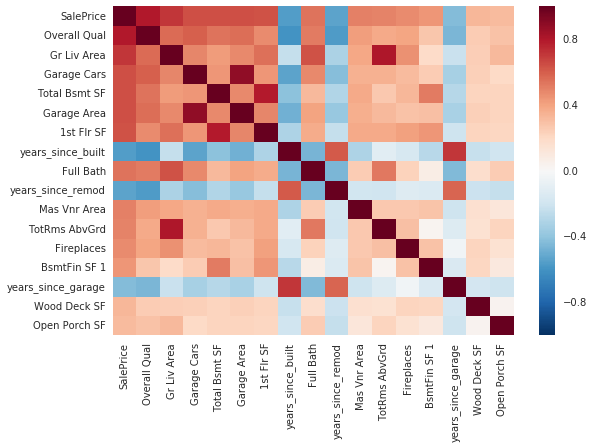

In [22]:
# create a correlation heatmap of the numerical features
corr_matrix = numerical_df[strong_corrs.index].corr()
sns.heatmap(corr_matrix)

In [23]:
# review some of the features with correlations closest to +1 or -1
corr_matrix[['Garage Area', '1st Flr SF', 'years_since_built', 'TotRms AbvGrd']]

,Garage Area,1st Flr SF,years_since_built,TotRms AbvGrd
SalePrice,0.641505,0.635042,-0.558788,0.498784
Overall Qual,0.561417,0.474637,-0.596142,0.376452
Gr Liv Area,0.480455,0.547001,-0.240372,0.806118
Garage Cars,0.888869,0.440982,-0.536627,0.353531
Total Bsmt SF,0.482361,0.792141,-0.408937,0.266593
Garage Area,1.000000,0.488648,-0.479588,0.322246
1st Flr SF,0.488648,1.000000,-0.310610,0.377263
years_since_built,-0.479588,-0.310610,1.000000,-0.110383
Full Bath,0.405240,0.372664,-0.468015,0.528785
years_since_remod,-0.375086,-0.241513,0.612615,-0.197471


From the above correlations, for most features the correlations are low enough (in absolute value terms) that I am not too concerned with possible multicollinearity.  However, a couple are on the high side to look at more closely.

Consider `Total Bsmt SF` and `1st Flr SF` with a correlation of 0.792141, or `Gr Liv Area` and `TotRms AbvGrd` with a correlation of 0.806118, or `Garage Cars` and `Garage Area` with a correlation of 0.888869.

For the first two pairs, I am okay with leaving these in for now.  For `Garage Cars` and `Garage Area`, both of these are direct measures of how big the garage is (one is number of cars that the garage holds while the other is how many square feet the garage covers).  Since these both measure garage size and they are relatively highly correlated, I will drop one of these features - `Garage Cars`.

In [24]:
# which remaining features are supposed to be categorial
# review data description for details
categoricals = ['MS SubClass', 'MS Zoning', 'Street', 'Lot Shape', 
                'Land Contour', 'Utilities', 'Lot Config', 
                'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 
                'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 
                'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond', 
                'Foundation', 'Heating', 'Heating QC', 'Central Air', 
                'Kitchen Qual', 'Functional', 'Paved Drive', 'Misc Val']

In [25]:
# let's look at numbers of unique codes in each of these features
unique_codes = transform_df[categoricals].apply(lambda col: len(col.value_counts())).sort_values(ascending=False)
unique_codes

Misc Val        37
Neighborhood    28
Exterior 2nd    17
Exterior 1st    16
MS SubClass     16
Condition 1      9
Condition 2      8
Roof Matl        8
Functional       8
House Style      8
MS Zoning        7
Heating          6
Roof Style       6
Foundation       6
Kitchen Qual     5
Bldg Type        5
Exter Cond       5
Lot Config       5
Heating QC       5
Exter Qual       4
Land Contour     4
Lot Shape        4
Paved Drive      3
Land Slope       3
Utilities        3
Central Air      2
Street           2
dtype: int64

In [26]:
# let's drop any columns with more than 10 unique values
# this would create a lot of columns when we dummy code these columns
drop_unique_codes = unique_codes[unique_codes > 10].index
drop_unique_codes

Index(['Misc Val', 'Neighborhood', 'Exterior 2nd', 'Exterior 1st',
       'MS SubClass'],
      dtype='object')

In [27]:
transform_df = transform_df.drop(drop_unique_codes, axis=1)

In [28]:
# review remaining categoricals
transform_df.describe(include=['object'])

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,...,Roof Matl,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
count,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,...,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926
unique,7,2,4,4,3,5,3,9,8,5,...,8,4,5,6,6,5,2,5,8,3
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,CompShg,TA,TA,PConc,GasA,Ex,Y,TA,Typ,Y
freq,2269,2914,1859,2632,2923,2137,2785,2519,2897,2421,...,2883,1799,2545,1306,2881,1491,2730,1494,2724,2648


It appears that there are a number of features where more than 95% of the values belong to one category.  These are very low variability features that will add little to our model (there is little variability for our model to capture).

Let's drop any feature where the frequency of the top category is more than 95% of the values of that feature.

In [29]:
cats = transform_df.describe(include=['object'])
freq = cats.iloc[3, :]
bad_freq = freq[freq >= 2780]
bad_freq

Street         2914
Utilities      2923
Land Slope     2785
Condition 2    2897
Roof Matl      2883
Heating        2881
Name: freq, dtype: object

In [30]:
# are any of our categoricals currently numerical?
cats_filtered = ['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 
                 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 
                 'Exter Qual', 'Exter Cond', 'Foundation', 'Heating QC', 
                 'Central Air', 'Kitchen Qual', 'Functional', 'Paved Drive']

transform_df[cats_filtered].select_dtypes(exclude=['object']).columns

Index([], dtype='object')

None of our remaining categoricals are currently numeric columns, so no adjustments need to be made for this potential issue.

In [31]:
# create dummy variables for our categoricals
# use prefix since many categories have similar values
# this will keep unique names for all our features
cat_df = transform_df[cats_filtered]
for col in cats_filtered:
    cat_df = pd.concat([cat_df, pd.get_dummies(cat_df[col], prefix=col)], axis=1)
    cat_df = cat_df.drop([col], axis=1)
    
cat_df.head()

,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


Now let's incorporate everything above into our `select_features` function.

In [32]:
# revise our select_features function based on the above work
def select_features(df):
    # remove numerical features with low correlation with our target
    numerical_df = df.select_dtypes(exclude=['object'])
    corr_with_price = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)
    weak_corrs = corr_with_price[corr_with_price <= 0.30]
    df = df.drop(weak_corrs.index, axis=1)
    df = df.drop(['Garage Cars'], axis=1)
    
    # review categoricals
    categoricals = ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 
                    'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 
                    'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 
                    'Roof Style', 'Roof Matl', 'Exterior 1st', 
                    'Exterior 2nd', 'Exter Qual', 'Exter Cond', 
                    'Foundation', 'Heating', 'Heating QC', 'Central Air', 
                    'Kitchen Qual', 'Functional', 'Paved Drive']
    
    # drop those with too many categories
    unique_codes = df[categoricals].apply(lambda col: len(col.value_counts())).sort_values(ascending=False)
    drop_unique_codes = unique_codes[unique_codes > 10].index
    df = df.drop(drop_unique_codes, axis=1)
    
    # drop those with too little variation
    cats = df.describe(include=['object'])
    freq = cats.iloc[3, :]
    bad_freq = freq[freq >= 2780]
    df = df.drop(bad_freq.index, axis=1)
    
    # create dummy variables for our categoricals
    cats_filtered = df.select_dtypes(include=['object']).columns
    for col in cats_filtered:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        df = df.drop([col], axis=1)
    
    return df

In [33]:
# re-run the model with our revised select_features function
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

32951.62573435863

## Training and Testing

Next, let's update the train_and_test function to incorporate cross validation.  We can incorporate several types:

- k = 0: holdout validation
    - assign the first 1460 rows to train and the remainder to test
    - train on train; test on test
    - return the RMSE
- k = 1: simple cross validation
    - shuffle the row ordering
    - assign the first 1460 rows to fold_one and the remainder to fold_two
    - train on fold_one; test on fold_two
    - train on fold_two; test on fold_one
    - return the average RMSE
- k > 1: k-fold cross validation
    - perform k-fold cross validation using k folds
    - return the avereage RMSE

In [34]:
# revise train_and_test() to incorporate the above
# add a parameter k
def train_and_test(df, k=10):
    features = df.columns.drop('SalePrice')
    
    # when k=0, this is the original function
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        
        X = train[features]
        y = train['SalePrice']
    
        reg = LinearRegression()
        reg.fit(X, y)
        predictions = reg.predict(test[features])
        rmse = mean_squared_error(test['SalePrice'], predictions) ** (1/2)
        return rmse
    
    # implement simple cross validation
    elif k == 1:
        shuffled_df = df.sample(frac=1, random_state=1)
        fold_one = shuffled_df[:1460]
        fold_two = shuffled_df[1460:]
        
        X1 = fold_one[features]
        X2 = fold_two[features]
        y1 = fold_one['SalePrice']
        y2 = fold_two['SalePrice']
        
        reg1 = LinearRegression()
        reg1.fit(X1, y1)
        predictions1 = reg1.predict(X2)
        rmse1 = mean_squared_error(y2, predictions1) ** (1/2)
        
        reg2 = LinearRegression()
        reg2.fit(X2, y2)
        predictions2 = reg2.predict(X1)
        rmse2 = mean_squared_error(y1, predictions2) ** (1/2)
        
        avg_rmse = (rmse1 + rmse2) / 2
        return avg_rmse
    
    # implement k-fold cross validation
    else:
        kf = KFold(k, shuffle=True, random_state=1)
        reg = LinearRegression()
        mses = cross_val_score(reg, df[features], df['SalePrice'], scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        avg_rmse = np.mean(rmses)
    
        return avg_rmse

In [35]:
# re-run the model with our revised train_and_test function
# k = 0 -- should match the previous run before modifying function
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=0)
rmse

32951.62573435863

In [36]:
# re-run for k = 1
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=1)
rmse

30060.068272526973

In [37]:
# re-run for larger k
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=5)
rmse

28659.96146634063

In [38]:
# re-run using default k
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

28194.484639731138